In [43]:
from sctoolbox.utils.jupyter import bgcolor, _compare_version

# change the background of input cells
bgcolor("PowderBlue", select=[3, 11, 15, 27])

nb_name = "02_QC_filtering.ipynb"

_compare_version(nb_name)

# 02 - QC and filtering
<hr style="border:2px solid black"> </hr>

## 1 - Description

For subsequent analysis, it is crucial to ensure that all cellular barcodes correspond to viable cells. Quality control (QC) is mandatory for RNA-seq data and focuses on three key aspects:

 1. The number of counts per barcode (count depth)
 2. The number of genes per barcode
 3. The fraction of reads derived from mitochondrial vs. nuclear origin
 
Outliers based on these covariates are filtered out. Such outliers may occur if a cell is dying, leading to broken membranes that cause mRNA leakage, resulting in low count depth and detected genes, along with elevated mitochondrial counts.

It is important to note that these covariates can vary between cell types. For example, cells involved in respiratory processes may have a higher mitochondrial content compared to other cells.

Therefore, cutoffs should be chosen to remove only outliers. This can be achieved automatically using algorithms such as median absolute deviation (MAD) or a Gaussian mixture model (GMM).


**DOI:** https://doi.org/10.1038/s41576-023-00586-w

_______

## 2 - Setup

In [44]:
import sctoolbox
import sctoolbox.utils as utils
import sctoolbox.tools.qc_filter as qc
import sctoolbox.tools.marker_genes as marker_genes
import sctoolbox.plotting as pl

import matplotlib.pyplot as plt
import pandas as pd

sctoolbox.settings.settings_from_config("config.yaml", key="02")

[WARNING] Log file '../logs/02_log.txt' already exists. The file will be overwritten since 'overwrite_log' is set to True.
[WARNING] Log file '../logs/02_log.txt' already exists. The file will be overwritten since 'overwrite_log' is set to True.


_________

## 3 - Load anndata
Uses the anndata object written by the previous notebook.

In [67]:
adata = utils.adata.load_h5ad("anndata_1.h5ad")

with pd.option_context("display.max.rows", 5, "display.max.columns", None):
    display(adata)
    display(adata.obs)
    display(adata.var)
    display(adata.obs['meta_sex'])

[INFO] The adata object was loaded from: ../adatas/anndata_1.h5ad


AnnData object with n_obs × n_vars = 3661 × 57031
    obs: 'TubeID', 'meta_TubeID', 'meta_pop_export_psn', 'meta_pop_visit_1_date', 'meta_pop_visit_2_date', 'meta_pop_visit_3_date', 'meta_pop_visit_4_date', 'meta_pop_age', 'meta_pop_age_dec', 'meta_pop_sex', 'meta_pop_c19_severity', 'meta_pop_cohort', 'meta_suep_hap_export_psn', 'meta_suep_hap_baseline_date', 'meta_suep_hap_end_acute_date', 'meta_suep_hap_end_acute_visit_date', 'meta_suep_hap_m3_fu_date', 'meta_suep_hap_m6_fu_date', 'meta_suep_hap_m12_fu_date', 'meta_suep_hap_m24_fu_date', 'meta_suep_hap_age', 'meta_suep_hap_age_dec', 'meta_suep_hap_sex', 'meta_suep_hap_c19_severity', 'meta_suep_hap_cohort', 'meta_export_psn', 'meta_age', 'meta_age_dec', 'meta_sex', 'meta_c19_severity', 'meta_cohort', 'rna_TubeID', 'rna_id', 'rna_fastq1', 'rna_project', 'rna_run', 'rna_plate', 'rna_organism', 'rna_assembly', 'rna_release', 'rna_parameters', 'rna_reads_processed', 'rna_reads_with_exactly_1_alignment', 'rna_reads_with_multiple_alignments

,TubeID,meta_TubeID,meta_pop_export_psn,meta_pop_visit_1_date,meta_pop_visit_2_date,meta_pop_visit_3_date,meta_pop_visit_4_date,meta_pop_age,meta_pop_age_dec,meta_pop_sex,meta_pop_c19_severity,meta_pop_cohort,meta_suep_hap_export_psn,meta_suep_hap_baseline_date,meta_suep_hap_end_acute_date,meta_suep_hap_end_acute_visit_date,meta_suep_hap_m3_fu_date,meta_suep_hap_m6_fu_date,meta_suep_hap_m12_fu_date,meta_suep_hap_m24_fu_date,meta_suep_hap_age,meta_suep_hap_age_dec,meta_suep_hap_sex,meta_suep_hap_c19_severity,meta_suep_hap_cohort,meta_export_psn,meta_age,meta_age_dec,meta_sex,meta_c19_severity,meta_cohort,rna_TubeID,rna_id,rna_fastq1,rna_project,rna_run,rna_plate,rna_organism,rna_assembly,rna_release,rna_parameters,rna_reads_processed,rna_reads_with_exactly_1_alignment,rna_reads_with_multiple_alignments,rna_reads_with_no_alignment,rna_reads_aligned,rna_pct_reads_aligned,rna_duplicate_reads,rna_pct_duplicate_reads,rna_mitochondrial_reads,rna_pct_mitochondrial_reads,rna_rrna_subunit_reads,rna_pct_rrna_subunit_reads,rna_pcr_bottleneck_coefficient,rna_mean_fragment_size_(only_for_paired-end),rna_reads_used_after_filters,rna_parameters.1,rna_reads_processed.1,rna_reads_assigned,rna_pct_reads_assigned_total,rna_pct_features_with_cpm_at_least_0.5,rna_unass._reads_overlapping_multiple_genes,rna_unass._reads_mapping_to_multiple_locations,rna_unass._reads_mapping_to_no_feature,rna_unass._reads_not_mapping,rna_unass._reads__bad_mapping_quality,rna_unass._reads__low_fragment_length,rna_unass._chimeric_reads,mapped_reads_over_2000000,rna_DDX3Y,rna_XIST,rna_gender,rna_sample_id_original,rna_plate_id_original,filename,rel_path
rna project.run id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
plt1.run1 pat_88,LV1007699778,LV1007699778,0,0,0,0,0,0.0,0,0,0,0,hap_0178,17/11/2021,24/11/2021,24/11/2021,0,0,0,0,65.0,60-69,M,severe,hap,hap_0178,65.0,60-69,M,severe,hap,LV1007699778,pat_88,AAAVY52HV_NAPKON_Plate1_2_22s004137-1-1_Valasa...,plt1,run1,plate1,human,hg38,104.0,"mode: single-end, keep duplicates: no, keep mu...","29,112,743","23,152,813","4,044,454","1,915,476","27,197,267",93.0,"20,093,139",73.0,"1,714,158",6.0,"1,868,907",6.0,0.28,0.0,"6,644,895",-t exon -g gene_id -s 2; multi-mapping: no; du...,"6,644,895","4,810,861",16.0,49.0,216.360,0.0,"1,617,674",0.0,0.0,0.0,0.0,True,844.0,8.0,M,Sample 49,Plate 1,matrix.mtx,.
plt1.run1 pat_89,LV1007699743,LV1007699743,0,0,0,0,0,0.0,0,0,0,0,suep_0425,08/11/2021,17/11/2021,17/11/2021,0,0,0,0,61.0,60-69,M,mild,suep,suep_0425,61.0,60-69,M,mild,suep,LV1007699743,pat_89,AAAVY52HV_NAPKON_Plate1_2_22s004137-1-1_Valasa...,plt1,run1,plate1,human,hg38,104.0,"mode: single-end, keep duplicates: no, keep mu...","24,355,220","13,253,462","7,713,379","3,388,379","20,966,841",86.0,"17,678,467",84.0,"1,475,002",7.0,"6,372,269",30.0,0.22,0.0,"2,989,995",-t exon -g gene_id -s 2; multi-mapping: no; du...,"2,989,995","2,155,768",8.0,45.0,97.961,0.0,"736,266",0.0,0.0,0.0,0.0,True,670.0,4.0,M,Sample 50,Plate 1,matrix.mtx,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
plt49.run1 pat_3571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,matrix.mtx,.
plt49.run1 pat_3572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,matrix.mtx,.


,Ensembl_gene,Ensembl_biotype,UniProt_proteins,UniProt_genes,UniProt_accessions,UniProt_names,UniProt_Ensembl_transcripts,UniProt_Ensembl_proteins,UniProt_Ensembl_gene_ids,Ensembl_chr,Ensembl_start,Ensembl_stop,Ensembl_strand,KEGG_PATHWAY_terms,KEGG_PATHWAY_ids,Gene_Ontology_terms,Gene_Ontology_ids
Ensembl gene id,,,,,,,,,,,,,,,,,
ENSG00000146555,SDK1,protein_coding,Protein sidekick-1,SDK1,Q7Z5N4; F8W6X9; A0A087WTQ6,SDK1_HUMAN; F8W6X9_HUMAN; A0A087WTQ6_HUMAN,ENST00000404826; ENST00000389531; ENST00000615806,ENSP00000385899; ENSP00000374182; ENSP00000478062,ENSG00000146555,chr7,3301252,4269000,+,NaN,NaN,"eye development, neural retina development, bi...","GO:0001654, GO:0003407, GO:0005488, GO:0005515..."
ENSG00000283537,ENSG00000283537,transcribed_unprocessed_pseudogene,NaN,NaN,NaN,NaN,NaN,NaN,ENSG00000283537,chr7,143620943,143645675,+,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000270696,ENSG00000270696,lncRNA,NaN,NaN,NaN,NaN,NaN,NaN,ENSG00000270696,chr2,75660462,75662208,+,NaN,NaN,NaN,NaN
ENSG00000229906,SNRPGP11,processed_pseudogene,NaN,NaN,NaN,NaN,NaN,NaN,ENSG00000229906,chr13,51496020,51496251,-,NaN,NaN,NaN,NaN


rna project.run id
plt1.run1 pat_88         M
plt1.run1 pat_89         M
                      ... 
plt49.run1 pat_3571    NaN
plt49.run1 pat_3572    NaN
Name: meta_sex, Length: 3661, dtype: category
Categories (3, object): ['0', 'F', 'M']

__________

## 4 - QC and filtering
<hr style="border:2px solid black"> </hr>

<h1><center>⬐ Fill in input data here ⬎</center></h1>

In [70]:
# Set the species of the data 
species = "human"  # available species: human, mouse, rat, zebrafish

# Set the column in adata.obs containing the biological condition to evaluate
condition_column = "meta_age_dec"

# Set the column in adata.var containing gene names (or set to None to use adata.var index)
gene_column = "Ensembl_gene"

# Absolute minimum number of genes for pre-selection of cells before QC plotting
min_genes = 1

# Decide whether to remove doublets using scrublet (True) or to skip doublet calculation (False)
# Set the threshold manually or use "None" for automatic threshold prediction
filter_doublets = False
threads = 4
doublet_threshold = None
use_native = None  # whether to use the scrublet package (set True in case of error)

# Whether to predict the sex of samples using the expression of a female gene.
predict_sex = True
# Name of the gene to use for the sex assignment.
# Note: gene expression can vary significantly across celltypes, disease and development stages. 
# Therefore, there is no guarantee that the example genes provided below will lead to accurate sex-determination.

# Examples by species:
# mouse: Xist https://www.science.org/doi/10.1126/science.adf1046
# human: XIST https://doi.org/10.1016/j.fsigen.2016.10.018
# rat: Xist https://www.science.org/doi/10.1126/science.adf1046
# zebrafish: rbpms2a, rbpms2b, foxl2 https://doi.org/10.1007/s00018-021-04066-4

female_gene = "XIST"

# Decide whether to estimate thresholds individual per condition (False) or globally (True)
global_threshold = True
# function used for automatic filtering.
# Either:
# qc.gmm_threshold (gaussian-mixture model),
# qc.mad_threshold (median aboslute deviation)
# or a custom function
filter_fun = qc.gmm_threshold
fun_kwargs = {  # additional parameters of the filter function
    "min_n": 3,  # Lower threshold (standard deviation) multiplier
    "max_n": 3  # Upper threshold (standard deviation) multiplier
}  

# Identify mitochondrial, ribosomal or gender genes
# 1. "internal" to use sctoolbox provided list, a list of gene names or a txt-file containing one gene per line or None
# 2. case insesitive regex pattern used as a fallback to option one
mito_list = "internal"  # 1.
mito_regex = "^mt"  # 2.
ribo_list = "internal"  # 1.
ribo_regex = "^rps|rpl"  # 2.
gen_list = "internal"  # 1.
gen_regex = None  # 2.

# Removal of Gene Subsets

# Decide whether to remove unwanted genes, such as mitochondrial, ribosomal, or gender-related genes. 
# This can reduce complexity and eliminate potential biases in subsequent analyses.
# Note: Removal is only possible if marker lists for these regions are available for the organism. 
# Marker lists are available by default for mouse, human, and rat.
filter_mito = False
filter_ribo = True
filter_gender = False

# Optional: Plot STARsolo quality if a path is given
quant_folder = ""
# correction of ambient RNA using scAR
# Caution this process is expensive and thus will take time to run!
# Requires the raw (unfiltered) AnnData object containing all droplets.
path_raw_adata = "/adatas/anndata_1.h5ad"  # The path to the raw h5ad file. Leave empty to skip.
epochs = 150  # Number of iterations for the model.

# overwrite previously applied sctoolbox filtering steps
# set to apply new filtering on top of previously applied filters
# Caution: Not recommended as it invalidates filter tracking
overwrite = False

________

In [54]:
# Ensure that the condition column is of type category
adata.obs[condition_column] = adata.obs[condition_column].astype("category")

### 4.1 - Show STARsolo quality (optional)

If the data was mapped using STARsolo, use the parameter to set the path to the STARsolo runs and plot quality measures across runs. The path must be a folder, e.g. "path/to/starsolo_output", which contains folders per condition e.g. "cond1", "cond2", etc.

In [55]:
if quant_folder != "":
    _ = pl.qc_filter.plot_starsolo_quality(quant_folder, save="starsolo_quality.pdf")
    _ = pl.qc_filter.plot_starsolo_UMI(quant_folder, ncol=3, save="starsolo_cell_selection.pdf")

_________

### 4.2 - Label genes
Mark genes on their general association. E.g. mitochondrial.

[INFO] Annotating mito genes...
[WARNING] Following genes are not present in the dataset. Please check for typos. ['MT-TF', 'MT-RNR1', 'MT-TV', 'MT-RNR2', 'MT-TL1', 'MT-ND1', 'MT-TI', 'MT-TQ', 'MT-TM', 'MT-ND2', 'MT-TW', 'MT-TA', 'MT-TN', 'MT-TC', 'MT-TY', 'MT-CO1', 'MT-TS1', 'MT-TD', 'MT-CO2', 'MT-TK', 'MT-ATP8', 'MT-ATP6', 'MT-CO3', 'MT-TG', 'MT-ND3', 'MT-TR', 'MT-ND4L', 'MT-ND4', 'MT-TH', 'MT-TS2', 'MT-TL2', 'MT-ND5', 'MT-ND6', 'MT-TE', 'MT-CYB', 'MT-TT', 'MT-TP']
[WARNING] No ribo genes available for species 'human'.
[WARNING] Falling back to regex '^rps|rpl'...
[INFO] Annotating ribo genes...
[INFO] Annotating gender genes...
[WARNING] Following genes are not present in the dataset. Please check for typos. ['PLCXD1', 'GTPBP6', 'LINC00685', 'PPP2R3B', 'Metazoa_SRP', 'FABP5P13', 'KRT18P53', 'SHOX', 'RPL14P5', 'CRLF2', 'CSF2RA', 'MIR3690', 'RNA5SP498', 'IL3RA', 'SLC25A6', 'LINC00106', 'ASMTL-AS1', 'ASMTL', 'P2RY8', 'AKAP17A', 'ASMT', 'DHRSX', 'DHRSX-IT1', 'ZBED1', 'MIR6089', 'CD99P1'

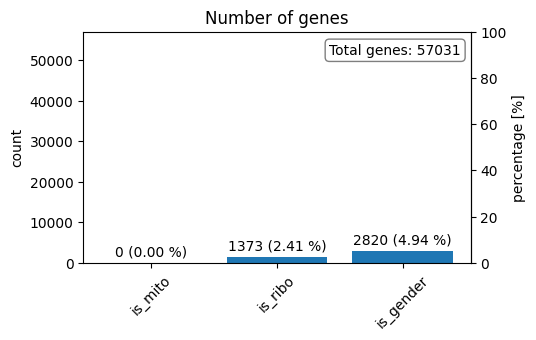

In [72]:
qc_vars = marker_genes.label_genes(adata,
                                   gene_column=gene_column,
                                   species=species,
                                   m_genes=mito_list,
                                   m_regex=mito_regex,
                                   r_genes=ribo_list,
                                   r_regex=ribo_regex,
                                   g_genes=gen_list,
                                   g_regex=gen_regex
                                  )

In [57]:
adata.obs

,TubeID,meta_TubeID,meta_pop_export_psn,meta_pop_visit_1_date,meta_pop_visit_2_date,meta_pop_visit_3_date,meta_pop_visit_4_date,meta_pop_age,meta_pop_age_dec,meta_pop_sex,...,rna_unass._reads__low_fragment_length,rna_unass._chimeric_reads,mapped_reads_over_2000000,rna_DDX3Y,rna_XIST,rna_gender,rna_sample_id_original,rna_plate_id_original,filename,rel_path
rna project.run id,,,,,,,,,,,,,,,,,,,,,
plt1.run1 pat_88,LV1007699778,LV1007699778,0,0,0,0,0,0.0,0,0,...,0.0,0.0,True,844.0,8.0,M,Sample 49,Plate 1,matrix.mtx,.
plt1.run1 pat_89,LV1007699743,LV1007699743,0,0,0,0,0,0.0,0,0,...,0.0,0.0,True,670.0,4.0,M,Sample 50,Plate 1,matrix.mtx,.
plt1.run1 pat_90,LV1007699757,LV1007699757,0,0,0,0,0,0.0,0,0,...,0.0,0.0,False,0.0,0.0,0,Sample 51,Plate 1,matrix.mtx,.
plt1.run1 pat_91,LV1007699878,LV1007699878,0,0,0,0,0,0.0,0,0,...,0.0,0.0,True,674.0,2.0,M,Sample 52,Plate 1,matrix.mtx,.
plt1.run1 pat_92,FR02512249,FR02512249,0,0,0,0,0,0.0,0,0,...,0.0,0.0,True,4.0,3512.0,F,Sample 53,Plate 1,matrix.mtx,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
plt49.run1 pat_3568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,matrix.mtx,.
plt49.run1 pat_3569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,matrix.mtx,.
plt49.run1 pat_3570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,nan,NaN,NaN,NaN,NaN,NaN,matrix.mtx,.


_________

### 4.3 - Calculate QC metrics
Create quality control metrics to filter the data on.

In [58]:
adata = qc.calculate_qc_metrics(adata, qc_vars=qc_vars)

_________

### 4.5 Calculate and remove doublets
Doublets are artifacts where two (doublet) or more (multiplet) cells receive the same barcode. As multiplets behave as a joined feature set of the collected cells they may show up as a separate group in downstream analysis, thus potentially skewing results. Therefore, it is recommended to remove doublets.

**DOI: [10.1016/j.cels.2018.11.005](https://doi.org/10.1016/j.cels.2018.11.005)**

In [60]:
# Set filter for number of genes before calculating doublets
n_cells_before = len(adata)
adata = adata[adata.obs["n_genes"] >= min_genes]
n_cells_after = len(adata)
print(f"Filtered out {n_cells_before-n_cells_after} cells which had less than {min_genes} gene(s) expressed.")

Filtered out 0 cells which had less than 1 gene(s) expressed.


In [61]:
if filter_doublets:
    qc.estimate_doublets(adata, groupby=condition_column, threads=threads, threshold=doublet_threshold, use_native=use_native)

<h1><center>⬐ Fill in input data here ⬎</center></h1>

In [62]:
# Remove predicted doublet
filter_doublets = True

In [ ]:
if filter_doublets:
    # Remove the duplicates from adata
    qc.filter_cells(adata, "predicted_doublet", name="doublet", overwrite=overwrite)

_________

### 4.5 - Predict sex per sample

[INFO] Normalizing adata
[INFO] Estimating male/female per group
[INFO] Plotting violins


KeyError: nan

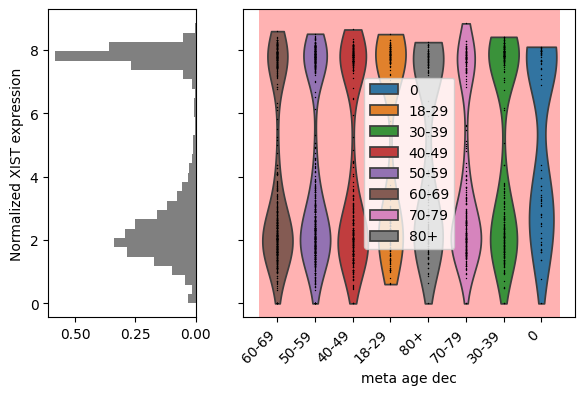

In [71]:
if predict_sex:
    qc.predict_sex(adata, groupby=condition_column, gene_column=gene_column, gene=female_gene, 
                   save="female_prediction.pdf")

_________

### 4.6 - Cell filtering
<hr style="border:1px solid black"> </hr>

Low and high count depth indicates cells with low integrity and doublets, respectively (DOI: 10.15252/msb.20188746).

In [64]:
# available obs columns
with pd.option_context("display.max.rows", 5, "display.max.columns", None):
    display(adata.obs)

,TubeID,meta_TubeID,meta_pop_export_psn,meta_pop_visit_1_date,meta_pop_visit_2_date,meta_pop_visit_3_date,meta_pop_visit_4_date,meta_pop_age,meta_pop_age_dec,meta_pop_sex,meta_pop_c19_severity,meta_pop_cohort,meta_suep_hap_export_psn,meta_suep_hap_baseline_date,meta_suep_hap_end_acute_date,meta_suep_hap_end_acute_visit_date,meta_suep_hap_m3_fu_date,meta_suep_hap_m6_fu_date,meta_suep_hap_m12_fu_date,meta_suep_hap_m24_fu_date,meta_suep_hap_age,meta_suep_hap_age_dec,meta_suep_hap_sex,meta_suep_hap_c19_severity,meta_suep_hap_cohort,meta_export_psn,meta_age,meta_age_dec,meta_sex,meta_c19_severity,meta_cohort,rna_TubeID,rna_id,rna_fastq1,rna_project,rna_run,rna_plate,rna_organism,rna_assembly,rna_release,rna_parameters,rna_reads_processed,rna_reads_with_exactly_1_alignment,rna_reads_with_multiple_alignments,rna_reads_with_no_alignment,rna_reads_aligned,rna_pct_reads_aligned,rna_duplicate_reads,rna_pct_duplicate_reads,rna_mitochondrial_reads,rna_pct_mitochondrial_reads,rna_rrna_subunit_reads,rna_pct_rrna_subunit_reads,rna_pcr_bottleneck_coefficient,rna_mean_fragment_size_(only_for_paired-end),rna_reads_used_after_filters,rna_parameters.1,rna_reads_processed.1,rna_reads_assigned,rna_pct_reads_assigned_total,rna_pct_features_with_cpm_at_least_0.5,rna_unass._reads_overlapping_multiple_genes,rna_unass._reads_mapping_to_multiple_locations,rna_unass._reads_mapping_to_no_feature,rna_unass._reads_not_mapping,rna_unass._reads__bad_mapping_quality,rna_unass._reads__low_fragment_length,rna_unass._chimeric_reads,mapped_reads_over_2000000,rna_DDX3Y,rna_XIST,rna_gender,rna_sample_id_original,rna_plate_id_original,filename,rel_path,n_genes,log1p_n_genes,total_counts,log1p_total_counts,total_counts_is_mito,log1p_total_counts_is_mito,pct_counts_is_mito,total_counts_is_ribo,log1p_total_counts_is_ribo,pct_counts_is_ribo,total_counts_is_gender,log1p_total_counts_is_gender,pct_counts_is_gender,predicted_sex
rna project.run id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
plt1.run1 pat_88,LV1007699778,LV1007699778,0,0,0,0,0,0.0,0,0,0,0,hap_0178,17/11/2021,24/11/2021,24/11/2021,0,0,0,0,65.0,60-69,M,severe,hap,hap_0178,65.0,60-69,M,severe,hap,LV1007699778,pat_88,AAAVY52HV_NAPKON_Plate1_2_22s004137-1-1_Valasa...,plt1,run1,plate1,human,hg38,104.0,"mode: single-end, keep duplicates: no, keep mu...","29,112,743","23,152,813","4,044,454","1,915,476","27,197,267",93.0,"20,093,139",73.0,"1,714,158",6.0,"1,868,907",6.0,0.28,0.0,"6,644,895",-t exon -g gene_id -s 2; multi-mapping: no; du...,"6,644,895","4,810,861",16.0,49.0,216.360,0.0,"1,617,674",0.0,0.0,0.0,0.0,True,844.0,8.0,M,Sample 49,Plate 1,matrix.mtx,.,23151,10.049836,4810335.0,15.386277,0.0,0.0,0.0,52602.0,10.870528,1.093521,155399.0,11.953757,3.230523,Female
plt1.run1 pat_89,LV1007699743,LV1007699743,0,0,0,0,0,0.0,0,0,0,0,suep_0425,08/11/2021,17/11/2021,17/11/2021,0,0,0,0,61.0,60-69,M,mild,suep,suep_0425,61.0,60-69,M,mild,suep,LV1007699743,pat_89,AAAVY52HV_NAPKON_Plate1_2_22s004137-1-1_Valasa...,plt1,run1,plate1,human,hg38,104.0,"mode: single-end, keep duplicates: no, keep mu...","24,355,220","13,253,462","7,713,379","3,388,379","20,966,841",86.0,"17,678,467",84.0,"1,475,002",7.0,"6,372,269",30.0,0.22,0.0,"2,989,995",-t exon -g gene_id -s 2; multi-mapping: no; du...,"2,989,995","2,155,768",8.0,45.0,97.961,0.0,"736,266",0.0,0.0,0.0,0.0,True,670.0,4.0,M,Sample 50,Plate 1,matrix.mtx,.,20116,9.909321,2155449.0,14.583510,0.0,0.0,0.0,31098.0,10.344931,1.442762,71275.0,11.174314,3.306736,Female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
plt49.run1 pat_3571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

Any numeric column shown above can be used as filter metric. Here is a description of the commonly available metrics:

| Metric | Description |
|--------|-------------|
|n_genes|The number of genes associated with a barcode (cell).|
|total_counts|The total amount of reads detected for this barcode (cell).|
|log1p_total_counts|Same as above but on a logarithmic scale.|
|total_counts_is_mito|The total amount of reads associated with mitochondrial genes.|
|log1p_total_counts_is_mito|Same as above but on a logarithmic scale.|
|pct_counts_is_mito|Percentage of mitochondrial reads per barcode (cell).|
|total_counts_is_ribo|The total amount of reads associated with ribosomal genes.|
|log1p_total_counts_is_ribo|Same as above but on a logarithmic scale.|
|pct_counts_is_ribo|Percentage of ribosomal reads per barcode (cell).|
|total_counts_is_gender|The total amount of reads associated with gender genes.|
|log1p_total_counts_is_gender|Same as above but on a logarithmic scale.|
|pct_counts_is_gender|Percentage of gender related reads per barcode (cell).|

In [73]:
# Decide whether to estimate thresholds individual per condition (False) or globally (True)
global_threshold = True

# Before filtering the impact of the individual filters are plotted by an UpSet plot.
# To restrict complexity of the plot the plotted combinations can be limited below.
limit_combinations = 2 # Either provide the combination grade as Integer or None to include all

# Set initial filter thresholds
# The thresholds can be interactively changed later on
# Note: Only metrics provided below are available for filtering
default_obs_thresholds = {
    'n_genes': {'min': None, 'max': None},
    'log1p_total_counts': {'min': None, 'max': None},
    'pct_counts_is_mito': {'min': None, 'max': None},
    'pct_counts_is_ribo': {'min': None, 'max': None},
    'pct_counts_is_gender': {'min': None, 'max': None}
    # add additional thresholds based on the available columns shown above
    # format: '<obs clolumn>': {'min': <threshold|None>, 'max': <threshold|None>}
    # None = automatically derive initial threshold
    # float('inf') or float('-inf') = no filter
}

#### 4.6.1 - Estimate initial thresholds automatically

In [74]:
groupby = condition_column if global_threshold is False else None
initial_obs_thresholds = qc.get_thresholds(adata,
                                       default_obs_thresholds,
                                       only_automatic=False,
                                       groupby=groupby)
obs_columns = list(initial_obs_thresholds.keys())
qc.thresholds_as_table(initial_obs_thresholds)

[WARNING] column n_genes not found in adata.obs
[WARNING] column log1p_total_counts not found in adata.obs
[WARNING] column pct_counts_is_mito not found in adata.obs
[WARNING] column pct_counts_is_ribo not found in adata.obs
[WARNING] column pct_counts_is_gender not found in adata.obs


""


The plot below estimates the impact each metric (and combination of metrics) would have on the data. Metrics that filter the same amount of cells independent of being alone or combined with other metrics can be disregarded as they have little effect on the overall outcome of the filtering.

In [75]:
_ = pl.qc_filter.upset_plot_filter_impacts(adata, 
                                           thresholds=initial_obs_thresholds, 
                                           groupby=groupby,
                                           limit_combinations=limit_combinations)

[INFO] Skipping UpSet Plot as only one threshold is given.


#### 4.6.2 - Customize thresholds via sliders

 (Rerun cell if plot is not shown)

In [76]:
%matplotlib widget

# Plot violins and sliders
obs_figure, obs_slider_dict = pl.qc_filter.quality_violin(
    adata,
    obs_columns,
    groupby=condition_column,
    which="obs",
    thresholds=initial_obs_thresholds,
    global_threshold=global_threshold,
    title="Cell quality control (before)",
    save="cell_filtering.png"
)
obs_figure

ZeroDivisionError: division by zero

In [78]:
plt.close()

# Get final thresholds
final_obs_thresholds = pl.qc_filter.get_slider_thresholds(obs_slider_dict)
qc.thresholds_as_table(final_obs_thresholds) # show thresholds

NameError: name 'obs_slider_dict' is not defined

In [ ]:
%matplotlib inline

_ = pl.qc_filter.upset_plot_filter_impacts(adata, 
                                           thresholds=final_obs_thresholds, 
                                           groupby=groupby,
                                           limit_combinations=limit_combinations)

In [ ]:
# Show pairwise comparisons of column values w/ thresholds (mean values in case thresholds are grouped)

if len(final_obs_thresholds) > 1:
    mean_thresholds = qc.get_mean_thresholds(final_obs_thresholds)
    _ = pl.general.pairwise_scatter(adata.obs, obs_columns, thresholds=mean_thresholds, save="cell_filtering_scatter.pdf")

#### 4.6.3 - Apply final thresholds
Filter the anndata object based on the thresholds in the threshold table.

In [ ]:
qc.apply_qc_thresholds(adata, which="obs", thresholds=final_obs_thresholds, overwrite=overwrite)

#### 4.6.4 - Show data after filtering

In [ ]:
%matplotlib inline 

# Plot violins and sliders
figure, slider_dict = pl.qc_filter.quality_violin(
    adata,
    obs_columns,
    groupby=condition_column,
    which="obs",
    ncols=3,
    global_threshold = global_threshold,
    title="Cell quality control (after)",
    save="cell_filtering_final.png"
)
figure

_________

### 4.7 - Gene filtering
<hr style="border:1px solid black"> </hr>
The following section is about filtering genes. The user can specify thresholds to filter by the number of cells.

In [ ]:
# Recalculate quality measures for genes
adata = qc.calculate_qc_metrics(adata)

In [ ]:
# Remove genes with 0 count
zero_bool = adata.var["n_cells_by_counts"] == 0
adata = adata[:,~zero_bool]

In [ ]:
# available var columns
with pd.option_context("display.max.rows", 5, "display.max.columns", None):
    display(adata.var)

Any numeric column shown above can be used as filter metric. Here is a description of the commonly available metrics:

| Metric | Description |
|--------|-------------|
|n_cells_by_counts|The number of cells that contain reads associated with the gene.|
|mean_counts|The mean amount of reads over all cells.|
|log1p_mean_counts|Same as above but on a logarithmic scale.|
|pct_dropout_by_counts|Percentage of cells this gene does not appear in.|
|total_counts|The total amount of reads associated to this gene.|
|log1p_total_counts|Same as above but on a logarithmic scale.|

<h1><center>⬐ Fill in input data here ⬎</center></h1>

In [ ]:
# Set initial filter thresholds
# The thresholds can be interctively changed later on
# Note: Only metrics provided below are available for filtering
default_var_thresholds = {
    'n_cells_by_counts': {'min': float('-inf'), 'max': float('inf')},
    'log1p_mean_counts': {'min': float('-inf'), 'max': float('inf')}
    # add additional thresholds based on the available columns shown above
    # format: '<obs clolumn>': {'min': <threshold|None>, 'max': <threshold|None>}
    # None = automatically derive initial threshold
    # float('inf') or float('-inf') = no filter
}

In [ ]:
initial_var_thresholds = qc.get_thresholds(adata, which="var", manual_thresholds=default_var_thresholds)

var_columns = list(initial_var_thresholds.keys())
qc.thresholds_as_table(initial_var_thresholds)

____________

#### 4.7.1 - Customize thresholds via sliders

 (Rerun cell if plot is not shown)

In [ ]:
%matplotlib widget

# Plot violins and sliders
var_figure, var_slider_dict = pl.qc_filter.quality_violin(
    adata,
    var_columns,
    which="var",
    title="Gene quality control (before)",
    save="gene_filtering.png"
)
var_figure

#### 4.7.2 - Apply gene filtering

In [ ]:
# Get final thresholds
final_var_thresholds = pl.qc_filter.get_slider_thresholds(var_slider_dict)
qc.thresholds_as_table(final_var_thresholds) # show thresholds

In [ ]:
qc.apply_qc_thresholds(adata, which="var", thresholds=final_var_thresholds, overwrite=overwrite)

#### 4.7.3 - Show data after filtering

In [ ]:
%matplotlib inline 

# Plot violins and sliders
figure, slider_dict = pl.qc_filter.quality_violin(
    adata,
    var_columns,
    which="var",
    ncols=3,
    title="Gene quality control (after)",
    save="gene_filtering_final.png"
)
figure

#### 4.7.4 - Filter additional marked genes
Remove genes that are labeled as e.g. mitochondrial genes.

In [ ]:
# Remove mitochrondrial genes
if filter_mito:
    print("Removing mitochrondrial genes:")
    qc.filter_genes(adata, "is_mito", name="mito", overwrite=overwrite)

# Remove ribosomal genes
if filter_ribo:
    print("Removing ribosomal genes:")
    qc.filter_genes(adata, "is_ribo", name="ribo", overwrite=overwrite)

# Remove gender genes
if filter_gender:
    print("Removing gender genes:")
    qc.filter_genes(adata, "is_gender", name="gender", overwrite=overwrite)

_________

### 4.8 - Denoising
Remove ambient RNA and technical noise from the count matrix using [scAR](https://www.biorxiv.org/content/10.1101/2022.01.14.476312v4). The tool estimates the ambient profile by averaging cell-free droplets. An autoencoder neural network later corrects the count matrix.
<hr style="border:1px solid black"> </hr>

In [ ]:
import scanpy as sc

if path_raw_adata:
    print("Loading raw anndata...")
    adata_raw = sc.read_h5ad(path_raw_adata)
    print("Denoising data, this will take a while...")
    adata = qc.denoise_data(adata, adata_raw, feature_type='Gene Expression', epochs=epochs,
                            verbose=False, save='droplets_kneeplot.pdf', overwrite=overwrite)

_________

## 5 - Save filtered adata
<hr style="border:2px solid black"> </hr>
Store the final results

In [ ]:
adata

In [ ]:
#Saving the data
adata_output = "anndata_2.h5ad"
utils.adata.save_h5ad(adata, adata_output)

In [ ]:
sctoolbox.settings.close_logfile()